导入库，数据

In [1]:
import scipy.io as spio         #该库用于load MAT文件
import numpy as np              #常规数据库
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
emgE1=spio.loadmat('S1_E1_A1.mat')
emgE2=spio.loadmat('S1_E2_A1.mat')
emgE3=spio.loadmat('S1_E3_A1.mat')
print(emgE1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


整合一个受试者数据的函数（将三个动作组和标签整合到一起，并去除休息片段）

In [3]:
def extractData(emgE1,emgE2,emgE3):
    #提取对应的标签数据
    label1=emgE1['restimulus']
    label2=emgE2['restimulus']
    label3=emgE3['restimulus']

    #提取三个Exercise的emg信号数据
    emg1=emgE1['emg']
    emg2=emgE2['emg']
    emg3=emgE3['emg']

    #创建空实例，用来存储动作数据
    E1=[]
    E2=[]
    E3=[]
    L1=[]
    L2=[]
    L3=[]

    #将休息片段（即：标签数据为0的部分）去除，只保留动作
    #每个动作组的长度不一致，单独创建循环

    for i in range(len(label1)):
        if label1[i] != 0:
            E1.append(emg1[i,:])
            L1.append(label1[i,:])
    E1=np.array(E1)                 #将list转换成array
    L1=np.array(L1)                 #将list转换成array

    for i in range(len(label2)):
        if label2[i] != 0:
            E2.append(emg2[i,:])
            L2.append(label2[i,:])
    E2=np.array(E2)
    L2=np.array(L2)

    for i in range(len(label3)):
        if label3[i] != 0:
            E3.append(emg3[i,:])
            L3.append(label3[i,:])
    E3=np.array(E3)
    L3=np.array(L3)

    #将三组动作整合成一个，标签也一样，并将标签的数值从0开始，一共49个动作
    EMG = np.vstack((E1,E2,E3))
    LABEL = np.vstack((L1,L2,L3))
    LABEL = LABEL - 1 
    return EMG, LABEL

(2397479, 12)
(2397479, 1)
[-1.9836700e-06 -1.2466978e-06  6.7001649e-09  3.8566882e-06
  3.4793222e-06 -1.1702260e-06  4.2410911e-06 -1.1763063e-05
  2.8292520e-06 -1.4126642e-06  1.9579038e-06 -2.2692848e-05]


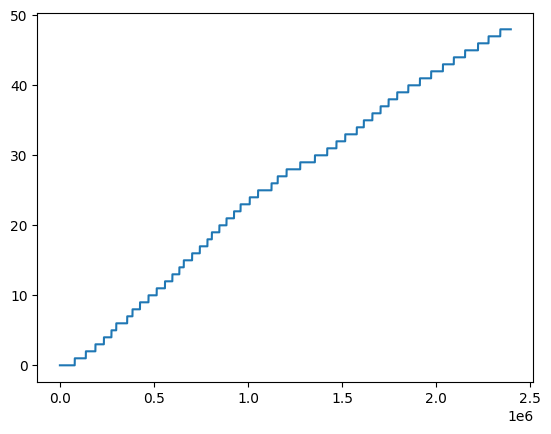

In [5]:
#打印数据形状
EMG,LABEL=extractData(emgE1,emgE2,emgE3)
print(EMG.shape)
print(LABEL.shape)
print(EMG[1,:])
plt.plot(LABEL)

定义时域特征计算函数，为了保证提取特征的连续性，采用时间窗方法

In [ ]:
print(LABEL)

[[ 0]
 [ 0]
 [ 0]
 ...
 [48]
 [48]
 [48]]


In [ ]:
#window_size：时间窗长度 W，increment: 增量窗 T，重合率 = (W-T)/T
#K时刻时间窗的尾端和K+1时刻时间窗的尾端之差等于T
#e.g：
#window_size = 200
#increment = 50

#wflength-80%，waveform length
#WL波形长度通常是指在一定时间范围内，信号波形的总长度或复杂度。
#在计算 WL 时，通常关注的是信号的变化量。
def FeatureWl(data):
    #用np.diff计算单通道，后一个数减前一个数的差值
    #再用np.abs求绝对值
    #最后用np.sum求和
    return np.sum(np.abs(np.diff(data,axis = 0)),axis = 0)

#MAV平均绝对值，关注信号的平均振幅
def FeatureMav(data):
    #axis=0表示从第0个通道开始对每个通道所有时间点的绝对值取平均
    #如果data形状为(200,12)，输出为(1,12)，200个时间点12个通道的数据被压缩成了一行
    return np.mean(np.abs(data), axis=0)

#var-79%
#VAR方差
def FeatureVar(data):
    #使用样本方差，因为特征提取是针对一组样本数据进行，而不是总体，能更好地反映样本数据的分布情况
    window_size = data.shape[0]
    #(data - np.mean(data,axis=0))**2: 对每个通道的单个数据减去平均，然后乘平方。数据形状不变
    #np.sum(......, axis=0)：对每个通道的数据求和
    vari = np.sum((data - np.mean(data,axis=0))**2, axis=0)
    return (vari / (window_size - 1))

def FeatureSSC(data, threshold=10e-7):
    delta = np.flip(np.diff(np.flip(data, axis=0), axis=0)[:-1], axis=0) * \
            np.diff(data, axis=0)[:-1]
    return np.sum(np.where(delta >= threshold, 1.0, 0.), axis=0)

def FeatureZC(data, threshold=10e-7):
    abs_diff = np.abs(np.diff(data, axis=0))
    sign = np.diff(np.sign(data), axis=0)
    log = np.logical_and(sign != 0, abs_diff > threshold)
    return np.sum(log, axis=0)


#skewness偏度
def FeatureSkewness(data):
    window_size = data.shape[0]
    # 计算均值
    mean = np.mean(data, axis=0)
    # 计算标准差
    vari = np.sum((data - np.mean(data,axis=0))**2, axis=0)
    vari= (vari / (window_size - 1))
    std_dev = np.sqrt(vari)
    # 计算偏度
    skewness = (np.sum((data - mean)**3, axis=0)) / (window_size * (std_dev**3))
    return skewness


In [ ]:
#window_size：时间窗长度 W，increment: 增量窗 T，重合率 = (W-T)/T
#K时刻时间窗的尾端和K+1时刻时间窗的尾端之差等于T
#e.g：
#window_size = 200
#increment = 0

#时域特征提取函数：（标签与数据一起）
#将数据按照时间窗和增量窗分成n个segment，segment含12通道，形状e.g.(200,12)
#每个segment都放进六个特征提取函数中得到六个(1,12)的数据，
#使用hstack组合六种特征数据，得到(1,72)
#每一轮储存seg，最后的特征数据形状应该是（n,72）

def extract_features(data, label, window_size, increment, k):
    featureData=[]
    featureLabel=[]
    #得到每个维度数据长度
    datalength = data.shape[0]
    #设置时间窗和步长
    timeWindow = window_size
    strideWindow = window_size - increment
    
    #为了保证数据的相关性，遍历类别，对每个类别执行操作
    #如：姿势1的emg信号与姿势2的分开进行图像化处理
    #以此防止干扰模型的判断  
    #在k个动作中，按循环，将每个动作的emg信号单独提取出来进行时间窗特征处理
    for i in range(k):
        index = []
        for j in range(datalength):
            if (label[j] == i):
                index.append(j)
        seg_emg = data[index,:]
        #计算每个动作能提取的时间窗数量
        #剔除每个动作结束阶段的窗口数据
        #是因为该部分可能包含姿势变换期间产生的非典型EMG信号，导致数据可靠性存疑。
        num_windows = (seg_emg.shape[0] - timeWindow) // strideWindow 
        
        #对数量进行循环提取出时间窗大小的数据进行特征计算
        for j in range(num_windows):
            #时间窗数据点的开头和结尾
            initial = strideWindow*j
            end = initial + timeWindow
            #计算特征
            wl   = FeatureWl(seg_emg[initial:end,:])
            mav  = FeatureMav(seg_emg[initial:end,:])
            var  = FeatureVar(seg_emg[initial:end,:])
            ssc  = FeatureSSC(seg_emg[initial:end,:])
            zc  = FeatureZC(seg_emg[initial:end,:])
            skew = FeatureSkewness(seg_emg[initial:end,:])
            #将特征数据水平堆叠起来
            feature = np.hstack((wl,mav,var,ssc,zc,skew))
            #储存特征数据和对应标签至列表
            featureData.append(feature)
            featureLabel.append(i)
        
    #将特征数据转化为数组
    featureData = np.array(featureData)
    featureLabel = np.array(featureLabel)
    featureLabel = featureLabel.reshape(-1, 1)
    #返还特征数据和特征标签
    return featureData, featureLabel

转化为图像数据

In [ ]:
def getImage(data,label,image_length,k):
    #初始化数据结构
    imageData=[]
    imageLabel=[]
    length = image_length
    datalength=label.shape[0]
    
    #原始数据准备, 将数据放大以便分析
    data = data*20000
            
    #为了保证数据的相关性，遍历类别，对每个类别执行操作
    #如：姿势1的emg信号与姿势2的分开进行图像化处理
    #以此防止干扰模型的判断
    for i in range(k):
        index = []
        for j in range(datalength):
            #提取类别特定的样本索引
            if (label[j] == i):
                index.append(j)
        #提取类别特定标签下的EMG数据
        seg_emg = data[index,:]
        
        #计算可提取的图像样本数量
        #剔除每个动作结束阶段的窗口数据
        #是因为该部分可能包含姿势变换期间产生的非典型EMG信号，导致数据可靠性存疑。
        num_windows = (seg_emg.shape[0] - length) // length

        #提取图像样本
        for j in range(num_windows):
            #图像数据点的开头和结尾，单个图像形状为[200,12]
            initial = length*j
            end = length*(j+1)
            #生成图像数据
            image = seg_emg[initial:end,:]
            #储存图像数据和对应标签至列表
            imageData.append(image)
            imageLabel.append(i)
    
    #数据转换
    imageData = np.array(imageData)
    imageLabel = np.array(imageLabel)
    imageLabel = imageLabel.reshape(-1, 1)
    return imageData, imageLabel

In [ ]:
image_length=200
classes = 49
imageData,imageLabel = getImage(EMG,LABEL,image_length,classes)

In [ ]:
print(imageData.shape)
print(imageLabel.shape)
print(imageLabel)

(11914, 200, 12)
(11914, 1)
[[ 0]
 [ 0]
 [ 0]
 ...
 [48]
 [48]
 [48]]


In [ ]:
import h5py
#file = h5py.File('DB2_S2_feature_200_0.h5','w')  
#file.create_dataset('featureData', data = featureData)  
#file.create_dataset('featureLabel', data = featureLabel)  
#file.close()  

file = h5py.File('DB2_S1_image_200_0.h5','w')  
file.create_dataset('imageData', data = imageData)  
file.create_dataset('imageLabel', data = imageLabel)  
file.close()  
